# Amazon Video Game Data Wrangling

Data from
> Justifying recommendations using distantly-labeled reviews and fined-grained aspects
Jianmo Ni, Jiacheng Li, Julian McAuley
Empirical Methods in Natural Language Processing (EMNLP), 2019

In [1]:
# import packages
import re
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict, deque
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve
%matplotlib inline

# load English tokenizer, tagger, parser, NER, and word vectors
nlp = spacy.load('en_core_web_sm')
import string
punctuations = string.punctuation
from  spacy.lang.en.stop_words import STOP_WORDS
# Creating a Spacy Parser
from spacy.lang.en import English
from stemming.porter2 import stem
from html import unescape
import fasttext
import emoji

In [2]:
# initialize spark and koalas
# import findspark
# findspark.init()
# import pyspark
# import databricks.koalas as ks

In [3]:
# from pyspark import SparkConf, SparkContext
# from pyspark.sql import SQLContext
# # set the app and number of cores to use (work comp 2 cores)
# # conf = SparkConf().setMaster('local[2]').setAppName('VideoGamesWrangle') # 2 for BB comp
# conf = SparkConf().setMaster('local[4]').setAppName('VideoGamesWrangle') # 4 for my laptop
# # set the sparkcontext
# sc = SparkContext.getOrCreate(conf = conf)
# sqlContext = SQLContext(sc)

In [2]:
vg = pd.read_json('../Amazon_Data/Video_Games_5.json.gz', lines=True, compression='gzip')

In [3]:
vg.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5,True,"10 17, 2015",A1HP7NVNPFMA4N,0700026657,Ambrosia075,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,1445040000,NaN,NaN,NaN
1,4,False,"07 27, 2015",A1JGAP0185YJI6,0700026657,travis,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",1437955200,NaN,NaN,NaN
2,3,True,"02 23, 2015",A1YJWEXHQBWK2B,0700026657,Vincent G. Mezera,ok game.,Three Stars,1424649600,NaN,NaN,NaN
3,2,True,"02 20, 2015",A2204E1TH211HT,0700026657,Grandma KR,"found the game a bit too complicated, not what...",Two Stars,1424390400,NaN,NaN,NaN
4,5,True,"12 25, 2014",A2RF5B5H74JLPE,0700026657,jon,"great game, I love it and have played it since...",love this game,1419465600,NaN,NaN,NaN


In [4]:
vg = vg.loc[:,['overall', 'reviewText']]

## Notes
- 'asin' = product ID
- 'reviewText' = the review text
- 'overall' = the star rating

In [5]:
vg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497577 entries, 0 to 497576
Data columns (total 2 columns):
overall       497577 non-null int64
reviewText    497419 non-null object
dtypes: int64(1), object(1)
memory usage: 7.6+ MB


In [6]:
# clean up nan values and change datatype
vg = vg.dropna(how='any')
vg.loc[:,'overall'] = vg.overall.astype('int16')

In [7]:
vg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 497419 entries, 0 to 497576
Data columns (total 2 columns):
overall       497419 non-null int16
reviewText    497419 non-null object
dtypes: int16(1), object(1)
memory usage: 8.5+ MB


In [8]:
vg.shape

(497419, 2)

In [9]:
vg.overall.value_counts()

5    299623
4     93644
3     49140
1     30879
2     24133
Name: overall, dtype: int64

In [10]:
# map the sentiment
vg.loc[:,'sentiment'] = vg.overall.map({1: 1, 2: 1, 3: 2, 4: 3, 5: 3}).astype('category')

In [11]:
# map the sentiment
vg.loc[:,'ft_sentiment'] = vg.overall.map({1: '__label__1 ', 2: '__label__1 ', 3: '__label__2 ', 
                                           4: '__label__3 ', 5: '__label__3 '}).astype('category')

In [12]:
vg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 497419 entries, 0 to 497576
Data columns (total 4 columns):
overall         497419 non-null int16
reviewText      497419 non-null object
sentiment       497419 non-null category
ft_sentiment    497419 non-null category
dtypes: category(2), int16(1), object(1)
memory usage: 9.5+ MB


In [13]:
vg.sentiment.value_counts()

3    393267
1     55012
2     49140
Name: sentiment, dtype: int64

In [14]:
vg.ft_sentiment.value_counts()

__label__3     393267
__label__1      55012
__label__2      49140
Name: ft_sentiment, dtype: int64

In [12]:
# create a dataframe from the word matrix
# def wm2df(wm, feat_names):
    
#     # create an index for each row
#     doc_names = ['Doc{:d}'.format(idx) for idx, _ in enumerate(wm)]
#     df = pd.DataFrame(data=wm.toarray(), index=doc_names,
#                       columns=feat_names)
#     return(df)

In [15]:
# generate and edit stop words
stops = list(STOP_WORDS)
print(stops)

['have', 'both', 'becomes', 'how', 'about', 'here', 'along', 'such', "'d", 'everywhere', 'becoming', 'since', 'still', 'make', 'above', 'behind', '’m', 'together', 'could', 'top', 'would', 'while', 'over', 'but', 'nine', 'all', 'which', '’ve', 'if', 'where', 'whereas', 'none', 'to', 'even', 'for', 'beforehand', 'has', 'whole', '‘s', 're', 'namely', 'as', 'us', 'is', 'cannot', 'else', 'his', 'noone', 'nowhere', 'ourselves', 'just', 'its', 'meanwhile', 'show', 'anyway', 'seem', 'this', 'whenever', 'beside', 'yet', 'your', 'fifteen', 'anywhere', 'under', "'ll", 'was', 'become', 'down', 'themselves', 'last', 'twelve', 'no', 'only', 'hereby', 'few', 'their', "'m", 'must', 'he', 'on', 'then', 'until', 'throughout', 'whereupon', 'out', 'put', 'further', 'you', '‘re', 'otherwise', 'therein', 'during', 'same', 'enough', 'had', 'i', 'one', 'side', 'more', 'thru', 'might', 'former', 'full', 'it', 'seeming', 'fifty', 'hereafter', '‘ll', 'back', 'became', 'however', 'latterly', 'hers', 'quite', 'be

In [16]:
stop_words = []
for word in stops:
    if word not in ['not', 'no', 'cannot', 'nothing', 'well', 'never', 'whatever']:
        stop_words.append(word)
# add additional stopwords
issue_words = ['\ufeff1', '\x16', '...', '\x10once']
for word in issue_words:
    stop_words.append(word)

In [17]:
print(stop_words)

['have', 'both', 'becomes', 'how', 'about', 'here', 'along', 'such', "'d", 'everywhere', 'becoming', 'since', 'still', 'make', 'above', 'behind', '’m', 'together', 'could', 'top', 'would', 'while', 'over', 'but', 'nine', 'all', 'which', '’ve', 'if', 'where', 'whereas', 'none', 'to', 'even', 'for', 'beforehand', 'has', 'whole', '‘s', 're', 'namely', 'as', 'us', 'is', 'else', 'his', 'noone', 'nowhere', 'ourselves', 'just', 'its', 'meanwhile', 'show', 'anyway', 'seem', 'this', 'whenever', 'beside', 'yet', 'your', 'fifteen', 'anywhere', 'under', "'ll", 'was', 'become', 'down', 'themselves', 'last', 'twelve', 'only', 'hereby', 'few', 'their', "'m", 'must', 'he', 'on', 'then', 'until', 'throughout', 'whereupon', 'out', 'put', 'further', 'you', '‘re', 'otherwise', 'therein', 'during', 'same', 'enough', 'had', 'i', 'one', 'side', 'more', 'thru', 'might', 'former', 'full', 'it', 'seeming', 'fifty', 'hereafter', '‘ll', 'back', 'became', 'however', 'latterly', 'hers', 'quite', 'before', 'bottom',

In [18]:
# remove html entities from docs and
# set everything to lowercase
def my_preprocessor(doc):
    return(unescape(doc).lower())

In [19]:
# define custom tokenizers
parser = English()
def my_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" 
                else word.lower_ for word in mytokens]
    mytokens = [word for word in mytokens if word not in stop_words and word not in punctuations]
    return mytokens

In [18]:
# alternate tokenizer using stemming


# parser = English()
# def my_tokenizer(sentence):
#     mytokens = parser(sentence)
#     mytokens = [stem(str(word)).lower().strip() for word in mytokens]
#     mytokens = [word for word in mytokens if word not in stop_words and word not in punctuations]
#     return mytokens

In [19]:
# my_tokenizer(vg.reviewText[33])

In [20]:
# create word_list function
def get_word_list(text, word_list):
    for sentence in text:
        for word in my_tokenizer(sentence):
            word_list.append(word)

In [20]:
# get a list of all words each time they occur in the reviews
# word_list = []
# for text in vg.reviewText:
#     for word in my_tokenizer(text):
#         word_list.append(word)

In [ ]:
# try using deque
# word_deque = deque()
# for text in vg.reviewText:
#     for word in my_tokenizer(text):
#         word_deque.append(word)

In [ ]:
# try using np array
# %%timeit
# word_array = np.array()
# for text in vg.reviewText:
#     for word in my_tokenizer(text):
#         word_array = np.append(word_array, word)

In [ ]:
# generate word_list
word_list = []
%timeit get_word_list(vg.reviewText, word_list)

In [18]:
# inspect the results
word_list[:20]

['game',
 'bite',
 'hard',
 'hang',
 'great',
 'play',
 'alright',
 'steam',
 'bite',
 'trouble',
 'game',
 'steam',
 'hard',
 'time',
 'activate',
 'play',
 'game',
 'spite',
 'fun',
 'like']

In [19]:
# check for anomalous words that start with a randomly chosen special character
for word in word_list:
    if word.startswith('\\'):
        print(word)

\/+b
\/+b
\"water
\/
\"water
\control
\jameson
\save_game
\save_game
\load_game
\save_game
\the
\/\/ords
\(^u^)/
\/
\/
\now
\have
\my
\\\
\(^0^)/
\|;;|
\and
\|;;|
\and
\program
\.
\much
\.
\m/
\ps3\update
\ps3\savedata
\ps3\export\psv
\m/
\m/(>_<)\m/
\m/\m/
\/.\/
\so
\\=()=//
\m/
\m/
\t/
\[t]/
\best
\_()_/.
\o/
\"water
\\
\(^u^)/


In [20]:
# check for anomalous words that start with a randomly chosen special character
for word in word_list:
    if word.startswith('\\'):
        print(emoji.demojize(word, use_aliases=True))

\/+b
\/+b
\"water
\/
\"water
\control
\jameson
\save_game
\save_game
\load_game
\save_game
\the
\/\/ords
\(^u^)/
\/
\/
\now
\have
\my
\\\
\(^0^)/
\|;;|
\and
\|;;|
\and
\program
\.
\much
\.
\m/
\ps3\update
\ps3\savedata
\ps3\export\psv
\m/
\m/(>_<)\m/
\m/\m/
\/.\/
\so
\\=()=//
\m/
\m/
\t/
\[t]/
\best
\_()_/.
\o/
\"water
\\
\(^u^)/


In [21]:
# create function to replace special chars
# def strip_spec_chars(word):
#     regex = re.compile('[\\\[\]@_!#$%^&*()<>?/\|}{~:]')
#     if regex.search(word) == None:
#         return word
#     else:
#         word = word.replace('[', '')
#         word = word.replace(']', '')
#         word = word.replace('@', '')
#         word = word.replace('_', '')
#         word = word.replace('!', '')
#         word = word.replace('#', '')
#         word = word.replace('$', '')
#         word = word.replace('%', '')
#         word = word.replace('^', '')
#         word = word.replace('&', '')
#         word = word.replace('*', '')
#         word = word.replace('(', '')
#         word = word.replace(')', '')
#         word = word.replace('<', '')
#         word = word.replace('>', '')
#         word = word.replace('?', '')
#         word = word.replace('/', '')
#         word = word.replace('\\', '')
#         word = word.replace('|', '')
#         word = word.replace('}', '')
#         word = word.replace('{', '')
#         word = word.replace('~', '')
#         word = word.replace(':', '')
#     if word != '':
#         return word

In [21]:
# alternate remove chars function
def rmv_spec_chars(sentence):
    sentence = re.sub("[\\\[\]@_!#$%^&*()<>?/\|}{~:']", '', sentence)
    sentence = re.sub('-', ' ', sentence)
    return sentence

In [22]:
rmv_spec_chars("This 'is' going * to be! a test \/(--)\/ train-test-split")

'This is going  to be a test    train test split'

In [22]:
#[strip_spec_chars(word) for word in vg.reviewText[20]]

In [23]:
# edit tokenizer to deal with tokens with special characters
def my_tokenizer(sentence):
    sentence = rmv_spec_chars(sentence)
    mytokens = parser(sentence)
    mytokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" 
                else word.lower_ for word in mytokens]
    mytokens = [emoji.demojize(word, use_aliases=True) for word in mytokens 
                if word not in stop_words and word not in punctuations]
    #mytokens = [word for word in mytokens if(regex.search(word) == None)]
    #mytokens = [strip_spec_chars(word) for word in mytokens if strip_spec_chars(word) != None]
    #mytokens = [word for word in mytokens if word != None]#filter(lambda x: x != None, mytokens)
    return mytokens

In [26]:
# modified alternate tokenizer using stemming
# def my_tokenizer(sentence):
#     sentence = rmv_spec_chars(sentence)
#     mytokens = parser(sentence)
#     mytokens = [stem(str(word)).lower().strip() for word in mytokens]
#     mytokens = [emoji.demojize(word, use_aliases=True) for word in mytokens 
#                 if word not in stop_words and word not in punctuations]
#     #mytokens = [word for word in mytokens if(regex.search(word) == None)]
#     #mytokens = [strip_spec_chars(word) for word in mytokens if strip_spec_chars(word) != None]
#     #mytokens = [word for word in mytokens if word != None]#filter(lambda x: x != None, mytokens)
#     return mytokens

In [24]:
# get a list of all words each time they occur in the reviews
word_list = []
get_word_list(vg.reviewText, word_list)

In [25]:
# inspect the results
word_list[:20]

['game',
 'bite',
 'hard',
 'hang',
 'great',
 'play',
 'alright',
 'steam',
 'bite',
 'trouble',
 'game',
 'steam',
 'hard',
 'time',
 'activate',
 'play',
 'game',
 'spite',
 'fun',
 'like']

In [26]:
# search for any anomalous words
regex = re.compile('[\\\[\]@_!#$%^&*()<>?/\|}{~:]')
for word in word_list:
    if regex.search(word) != None:
        print('Found at least one anomalous word: ' + word)
        break
else:
    print('No words fitting regular expression "regex"')

No words fitting regular expression "regex"


In [27]:
# check for anomalous words that start with a randomly chosen special character
for word in word_list:
    if word.startswith('\\'):
        print(word)

In [28]:
# display the total number of words included in the vocabulary
print('The number of words in the reviews is {}'.format(len(word_list)))

The number of words in the reviews is 27846714


In [29]:
# get a count of every word
token_counts = Counter(word_list)

In [30]:
type(token_counts)

collections.Counter

In [31]:
token_counts['\x10once']

0

In [32]:
token_counts.most_common(20)

[('game', 1269540),
 ('not', 779101),
 ('play', 392038),
 ('like', 312056),
 ('good', 300752),
 ('time', 210322),
 ('great', 204217),
 ('well', 175132),
 ('use', 163086),
 ('fun', 157620),
 ('no', 137469),
 ('little', 119941),
 ('character', 119473),
 ('buy', 118731),
 ('new', 114251),
 ('2', 113918),
 ('look', 112552),
 ('story', 109687),
 ('thing', 108672),
 ('love', 108454)]

In [33]:
print('The total number of unique words is {}'.format(len(token_counts)))

The total number of unique words is 252075


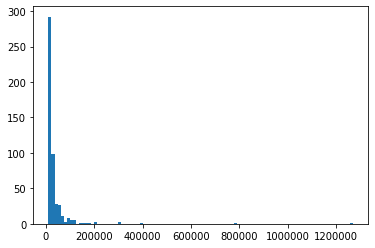

In [34]:
# create histogram of word appearances
# most words occur infrequently, so threshold for num influences this plot greatly
values = []
for tup in token_counts.most_common():
    word, num = tup
    if num > 10000:
        values.append(num)
_ = plt.hist(values, bins=100)

In [31]:
# most words appear very infrequently

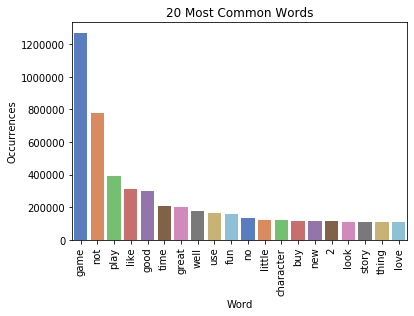

In [35]:
# plot the 20 most common words
words = []
values = []
for tup in token_counts.most_common(20):
    word, num = tup
    words.append(word)
    values.append(num)
_ = sns.barplot(words, values, palette='muted')
_ = plt.xticks(rotation=90)
_ = plt.title('20 Most Common Words')
_ = plt.xlabel('Word')
_ = plt.ylabel('Occurrences')

In [36]:
# character decoding issues?
# seems to be solved using regex
print(my_tokenizer(vg.reviewText[6541]))

['buy', 'age', 'wonders', 'come', 'game', 'opinion', 'well', 'computer', 'fantasy', 'war', 'game', 'option', 'different', 'race', 'seven', 'different', 'sphere', 'magic', 'definitely', 'plenty', 'diversity', 'replay', 'value', 'game', 'spell', 'effect', 'charm', 'musical', 'score', 'beautiful', 'single', 'player', 'campaign', 'great', 'story', 'line', 'multi', 'player', 'aspect', 'single', 'scenario', 'good', 'develope', 'heroes', 'customizable', 'choose', 'actually', 'hero', 'represent', 'play', 'field', 'good', 'die', 'lose', 'thing', 'change', 'game', 'unit', 'icon', 'honest', 'artwork', 'icon', 'little', 'lack', 'like', 'rush', 'product', 'gate', 'age', 'wonders', 'awesome', 'game', 'definitely', 'look', 'forward', 'age', 'wonders', '2']


In [37]:
# add game to stop_words
stop_words.append('game')

In [38]:
# get a count of the number of reviews where a word appears
num_docs = defaultdict(int)
for text in vg.reviewText:
    ls = []
    for word in my_tokenizer(text):
        if word not in ls:
            ls.append(word)
    for x in ls:
        num_docs[x] += 1

In [39]:
# store a list of the number of appearances for each word
apps = []
for key, val in num_docs.items():
    apps.append(val)

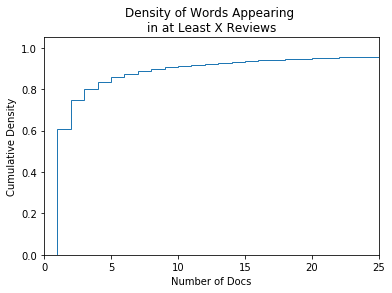

In [40]:
# plot the cdf for the number of reviews where each word appears
_ = plt.hist(apps, cumulative=True, histtype='step', density=True, bins=np.arange(100))
_ = plt.xlim(0,25)
_ = plt.xlabel('Number of Docs')
_ = plt.ylabel('Cumulative Density')
_ = plt.title('Density of Words Appearing \nin at Least X Reviews')

In [ ]:
# choosing 2 for min_df
# even though only about 40% of the non-stop words appear in two or more reviews

In [41]:
# import wordcloud
from wordcloud import WordCloud

In [42]:
# initialize wordcloud object
wc = WordCloud(background_color='white', stopwords=stop_words, max_words=200, 
               max_font_size=40, scale=3, random_state=42)

In [43]:
# generate the wordcloud
wc.generate(' '.join(word_list))

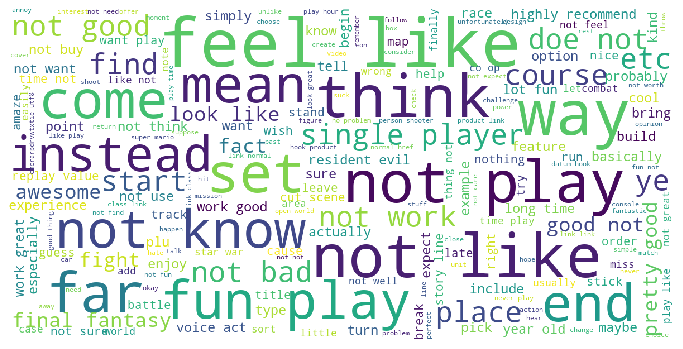

In [46]:
fig = plt.figure(1, figsize=(12, 12))
plt.axis('off')

plt.imshow(wc)
plt.show()

In [ ]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stop_words,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=42
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(word_list)

In [21]:
# split the data for fasttext
train_text, test_text, train_labels, test_labels = train_test_split(vg.reviewText, 
                                                                    vg.ft_sentiment, 
                                                                    test_size=0.25,
                                                                    random_state=42, 
                                                                    stratify=vg.ft_sentiment)

In [22]:
# split the training data into train and validation for hyperparameter tuning
train_text, valid_text, train_labels, valid_labels = train_test_split(train_text, train_labels, 
                                                                      test_size=0.25,
                                                                      random_state=42, 
                                                                      stratify=train_labels)

In [23]:
train_text.shape

(279798,)

In [24]:
type(train_text)

pandas.core.series.Series

In [25]:
train_text.index[:5]

Int64Index([218055, 260506, 495846, 446837, 80402], dtype='int64')

In [26]:
train_labels.index[:5]

Int64Index([218055, 260506, 495846, 446837, 80402], dtype='int64')

In [27]:
str.replace(train_text[218055], '\n', ' ')

'Pretty good helicopter game.  Realistic mode is very challenging even for a pilot like me.  My main chopper was a Huey Cobra, circa 1968 in Viet Nam, but this game is pretty well done.  Sure wish we had Sidewinders & Hellcats back then.'

In [28]:
train_labels[218055]

'__label__2 '

In [29]:
type(valid_text)

pandas.core.series.Series

In [30]:
valid_text.shape

(93266,)

In [ ]:
# process using fasttext
# prepare the text and labels for fasttext processing
# text = ''
# max_idx = max(vg.index.values)
# for idx in vg.index.values:
#     text += vg.loc[idx, 'ft_sentiment']
#     text += vg.loc[idx, 'reviewText']
#     text += '\n'
#     #if idx < max_idx:
#     #    text += '\n'

In [31]:
# write to file instead of to long text string
import os.path

max_idx = max(train_text.index.values)

if os.path.isfile('train.txt'):
    print ("File already created.")
else:
    with open('train.txt', 'w') as file:
        for idx in train_text.index.values:
            line = ''
            line += train_labels[idx]
            line += str.replace(train_text[idx], '\n', ' ')
            line += '\n'
            file.write(line)

File already created.


In [32]:
import os.path

max_idx = max(valid_text.index.values)

if os.path.isfile('valid.txt'):
    print ("File already created.")
else:
    with open('valid.txt', 'w') as file:
        for idx in valid_text.index.values:
            line = ''
            line += valid_labels[idx]
            line += str.replace(valid_text[idx], '\n', ' ')
            line += '\n'
            file.write(line)

File already created.


In [33]:
# write to file instead of to long text string
import os.path

max_idx = max(test_text.index.values)

if os.path.isfile('test.txt'):
    print ("File already created.")
else:
    with open('test.txt', 'w') as file:
        for idx in test_text.index.values:
            line = ''
            line += test_labels[idx]
            line += str.replace(test_text[idx], '\n', ' ')
            line += '\n'
            file.write(line)

File already created.


In [71]:
help(fasttext)

Help on package fasttext:

NAME
    fasttext

PACKAGE CONTENTS
    fasttext
    model

FUNCTIONS
    cbow(...)
    
    load_model(...)
    
    skipgram(...)
    
    supervised(...)

DATA
    __VERSION__ = '0.8.3'

FILE
    c:\programdata\anaconda3\lib\site-packages\fasttext\__init__.py




In [51]:
# load the pretrained model
#model = fasttext.load_model('model.bin')

In [38]:
model = fasttext.supervised('train.txt', 'model', label_prefix='__label__')

In [52]:
result = model.test('test.txt')
print('Precision:', result.precision)
print('Recall:', result.recall)
print('Number of examples:', result.nexamples)

Precision: 0.8444694624261188
Recall: 0.8444694624261188
Number of examples: 124355


In [49]:
y_pred = model.predict('This was a horrible game')

In [43]:
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve

In [46]:
# print the confusion matrix
print(confusion_matrix(test_labels, y_pred))
tn, fp, fn, tp = confusion_matrix(test_labels, y_pred).ravel()
dr = tp / (tp + fn)
fpr = fp / (fp + tn)
print('True Negatives: {}'.format(tn))
print('False Positives: {}'.format(fp))
print('False Negatives: {}'.format(fn))
print('True Positives: {}'.format(tp))
print('Detection Rate: {}'.format(dr))
print('False Positive Rate: {}'.format(fpr))

ValueError: Found input variables with inconsistent numbers of samples: [124355, 8]

In [71]:
# create vectorizer
vectorizer = CountVectorizer(min_df=2, analyzer='word', decode_error='replace', 
                             preprocessor=my_preprocessor, tokenizer=my_tokenizer)

In [72]:
# fit_transform the data
# vectorizer.fit(vg.reviewText.values)
# X_vec = vectorizer.transform(vg.reviewText.values)
X_vec = vectorizer.fit_transform(vg.reviewText.values)
X_vec = X_vec.tocsc()

In [73]:
# show the number of words meeting selection criteria
print('The number of words meeting selection criteria in the text data is {}'.format(X_vec.shape[1]))

The number of words meeting selection criteria in the text data is 95064


In [74]:
X_vec.shape

(497419, 95064)

In [75]:
# get the words from the vocabulary
words = np.array(vectorizer.get_feature_names())

In [76]:
len(words)

95064

In [86]:
# still some misspellings, but they show up at least twice!
print(words[4])
print(words[5465])
print(words[54545])
print(words[44599])
print(words[55465])
print(words[77121])

"----nope
3-lap
majot
hovertanks
maybeless
sinister


In [81]:
words[0]

'\x10once'

In [24]:
# create a dataframe from the X array for summary stats
# memory error
#df = ks.DataFrame(X_vec.toarray())

In [25]:
# create a dataframe to hold the number of reviews a word appears in
# num_appear = []
# tot = X_vec.shape[0]
# for i in range(X_vec.shape[1]):
#     num_appear.append(np.sum(X_vec!=0))
#     apps = np.array(num_appear)
#counts_df = pd.DataFrame({'apps': apps})

In [37]:
# what is this dtype??
words.dtype

dtype('<U2625')

In [26]:
# I think this will give me the vector I want (the sum of all columns)
apps = np.sum(X_vec!=0, axis=0)

In [27]:
apps.shape

(1, 228890)

In [28]:
apps[0]

matrix([[    1,     2,     1, ...,     1,     3, 75225]])

In [ ]:
# testing some np functions below

In [181]:
d = np.array([1, 0, 0, 4, 5, 0])

In [ ]:
d!=0

In [106]:
# return the indices for the most common words
# get the total number of appearances of each word
#x = np.eye(X_vec.shape[1])
count_vec=X_vec.sum(axis=0)[0, :]
idxs = np.argsort(count_vec)

In [20]:
# get the total number of appearances of each word
count_vec=X_vec.sum(axis=0)

In [21]:
count_vec.shape

(1, 231626)

In [54]:
for key, value in vectorizer.vocabulary_.items():
    for i in range(count_vec.shape[1]):
        

231626

In [ ]:
# create tfidf vectorizer
tfvectorizer = TfidfVectorizer(tokenizer = my_tokenizer)

In [14]:
# process the text from the tfidf vectorizer
# .vocabulary_ contains the dictionary of indices and words
# get_feature_names() also contains vocabulary
X_tfvec = tfvectorizer.fit_transform(vg.reviewText)
X_tfvec = X_tfvec.tocsc()

In [20]:
# split the data into features and target and train/test split
# X = vg.reviewText.values
y = vg.overall.values
X_train, X_test, y_train, y_test = train_test_split(X_tfvec, y, test_size=0.25, 
                                                    random_state=42, stratify=y)

In [21]:
# upsample the training data
train = pd.DataFrame({'overall': y_train, 'review_vector': X_train})

In [22]:
train.overall.value_counts()

5    224717
4     70233
3     36855
1     23159
2     18100
Name: overall, dtype: int64

In [23]:
# keep all of the indexes with a review of 5
# generate random samples of the other indexes to equal the value counts of 5
# break into pos (4,5), neutral (3), negative (1, 2)
train5 = train[train.overall == 5]
train4_idxs = np.random.choice(train[train.overall == 4].index, 225000, replace=True)
train3_idxs = np.random.choice(train[train.overall == 3].index, 550000, replace=True)
train2_idxs = np.random.choice(train[train.overall == 2].index, 225000, replace=True)
train1_idxs = np.random.choice(train[train.overall == 1].index, 225000, replace=True)

In [24]:
train5.overall.value_counts()

5    224717
Name: overall, dtype: int64

In [25]:
# upsample the data
train = pd.concat([train5, train.iloc[train1_idxs,:], train.iloc[train2_idxs,:], 
                   train.iloc[train3_idxs,:], train.iloc[train4_idxs,:]])

In [26]:
train.overall.value_counts()

4    225000
3    225000
2    225000
1    225000
5    224717
Name: overall, dtype: int64

In [36]:
train.head()

,overall,review_vector
1,5,"(0, 6421)\t0.04689702090419594\n (0, 13519)..."
2,5,"(0, 6421)\t0.04689702090419594\n (0, 13519)..."
3,5,"(0, 6421)\t0.04689702090419594\n (0, 13519)..."
4,5,"(0, 6421)\t0.04689702090419594\n (0, 13519)..."
6,5,"(0, 6421)\t0.04689702090419594\n (0, 13519)..."


In [28]:
train.shape

(1124717, 2)

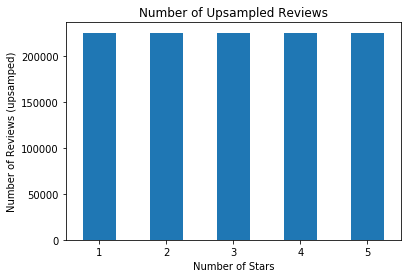

In [29]:
# display plot showing balanced data for training
_ = train.overall.value_counts().sort_index().plot(kind='bar')
_ = plt.title('Number of Upsampled Reviews')
_ = plt.xlabel('Number of Stars')
_ = plt.ylabel('Number of Reviews (upsamped)')
_ = plt.xticks(rotation=0)

In [30]:
# split training data into X, y
X_train = train.review_vector
y_train = train.overall.values

In [ ]:
# write a function to get the 10 words that occur the most